In [2]:
# Core libs
import pandas as pd
import numpy as np
import pickle

# Graphic libs
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
pio.renderers.default = "browser"

# sklearn 
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_absolute_percentage_error as LMAPE

# IA + blockchain = profit
import tensorflow as tf
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Lambda, Dropout, BatchNormalization, Activation, Dense, LeakyReLU, Add
from keras.layers.merging import Add, Concatenate
from keras.utils import plot_model, to_categorical

In [154]:
SIMPLE_COLUMNS = [
    'Fecha',
    'Calle',
    'Piso',
    'Departamento',
    'Provincia',
    'Distrito',
    'Estacionamiento',
    'Depositos',
    'Lat',
    'Lon',
    'Categoria',
    'Posicion',
    'Frentes',
    'Edad',
    'Elevador',
    'Conservacion',
    'Metodo',
    'Moneda',
    'AreaTerreno',
    'AreaConstruccion',
    'PromedioConstruccion',
    'PromedioTerreno',
    'Valorcomercial'
]

NUM_COLS = [
    'Fecha entrega del Informe', 
    'Tipo de vía',
    'Número de estacionamiento', #aug
    'Depósitos', #aug
    'Latitud (Decimal)', 
    'Longitud (Decimal)',
    'Número de frentes',
    'Edad', #aug
    'Elevador', 
    'Área Terreno', #aug
    'Área Construcción', #aug
    'Valor comercial (USD)',
]

CAT_COLS = [
    'Calle',
    'Piso', #irrelevant
    'Departamento', 
    'Provincia',  
    'Distrito',  
    'Categoría del bien', 
    'Posición', #irrelevant
    'Estado de conservación', 
    'Método Representado', #irrelevant
    'Moneda principal para cálculos'
]

TO_AUGMENT = [
    'Número de estacionamiento',
    'Depósitos',
    'Edad'
]

In [155]:
def string_convert(x):
    try:
        return float(x.replace(',',''))
    except ValueError:
        return 0.0
    


In [156]:
def data_sanitize_train(raw_data, train = False, region = None):

    if region is not None:
        ordinal_data = raw_data[raw_data[region[0]] == region[1]].copy()
    else:
        ordinal_data = raw_data.copy()

    ranva = pd.Series(np.random.randn(ordinal_data.shape[0]))
    ordinal_data = ordinal_data.assign(ranva=ranva.values)

    for column in raw_data[:-2]:
        dist_encod = OrdinalEncoder()

        if column in CAT_COLS:
            enc = dist_encod.fit_transform(ordinal_data[[column,'ranva']].to_numpy(dtype = str))
            ordinal_data[column] = enc.T[0]

    ordinal_data = ordinal_data.drop('ranva', axis = 1)

    ordinal_data = ordinal_data.applymap(lambda x : string_convert(x) if isinstance(x,str) else x)
    ordinal_data.columns = SIMPLE_COLUMNS
    scale_data = ordinal_data.applymap(lambda x : np.cbrt(x))

    if train:
        ground_truth = ordinal_data['Valorcomercial'].to_numpy()
        return scale_data, ground_truth
    
    return scale_data

def data_sanitize_test(raw_data, augment, region=None):
    augmented_data = raw_data.copy()

    ages = augmented_data['Edad'].to_numpy()
    dates = augmented_data['Fecha entrega del Informe'].to_numpy()

    for i, age in enumerate(ages):
        if age >= 1000:
            ages[i] = np.round(((dates[i] - pd.Timestamp(ages[i])).days)/365.0)

    augmented_data['Edad'] = ages

    augmented_data.insert(augmented_data.shape[1]-2, 'Precio promedio m2 (Terreno)', np.zeros(augmented_data.shape[0]))
    augmented_data.insert(augmented_data.shape[1]-2, 'Precio promedio m2 (Construcción)', np.zeros(augmented_data.shape[0]))

    augmented_data['Área Terreno'] = augmented_data['Área Terreno'].fillna(0.0)
    augmented_data['Área Construcción'] = augmented_data['Área Construcción'].fillna(0.0)

    for dep in raw_data['Departamento'].unique():

        dep_select = raw_data[raw_data['Departamento'] == dep]
        for prov in dep_select['Provincia'].unique():

            prov_select = dep_select[dep_select['Provincia'] == prov]
            for dist in prov_select['Distrito'].unique():
                query = raw_data[(raw_data['Departamento'] == dep) &
                                 (raw_data['Provincia'] == prov  ) &
                                 (raw_data['Distrito'] == dist   )]

                fault_key = False

                for augment_dim in TO_AUGMENT:
                    to_augment_array = np.array([val.replace(',','') if isinstance(val, str) else val for val in query[augment_dim].to_list()], dtype=np.float32)

                    try:
                        to_augment_array = np.nan_to_num(to_augment_array, nan = augment[(dep,prov,dist)][augment_dim])
                    except KeyError:
                        to_augment_array = np.nan_to_num(to_augment_array, nan = 0.0)
                        fault_key = True

                    full_array = augmented_data[augment_dim].to_numpy()                    
                    full_array[query.index] = to_augment_array

                    augmented_data[augment_dim] = full_array

                if fault_key: continue
                
                avg_bval_list = augmented_data['Precio promedio m2 (Construcción)'].to_numpy()
                avg_pval_list = augmented_data['Precio promedio m2 (Terreno)'].to_numpy()
                avg_bval_list[query.index] = augment[(dep,prov,dist)]['Precio promedio m2 (Construcción)']
                avg_pval_list[query.index] = augment[(dep,prov,dist)]['Precio promedio m2 (Terreno)']
                augmented_data['Precio promedio m2 (Construcción)'] = avg_bval_list
                augmented_data['Precio promedio m2 (Terreno)'] = avg_pval_list

    return data_sanitize_train(augmented_data.applymap(lambda x : (x - pd.Timestamp("1900-01-01 00:00:00")).days + 2 if isinstance(x,pd.Timestamp) else x).fillna(-1), train=True, region=region)

def pca_plot_plotly(data, hue, n_components = -1, out = []):
    if len(out) != 0:
        data = data.drop(out, axis = 1)

    plot_pca = PCA()
    plot_pca.fit(data)
    X = data.to_numpy().T

    if n_components != -1: 
        components = (plot_pca.components_[:n_components,:]@X).T
    else: 
        components = (plot_pca.components_@X).T
    
    components_df = pd.DataFrame(components, columns=['PC'+str(i+1)+' ({:.1f})%'.format(plot_pca.explained_variance_ratio_[i]*100) for i in range(components.shape[1])])

    fig = px.scatter_matrix(components_df,
        dimensions=['PC'+str(i+1)+' ({:.1f})%'.format(plot_pca.explained_variance_ratio_[i]*100) for i in range(components.shape[1])],
        color=hue,
        title="PCA Pairs plot",
        labels=components_df.columns)
    fig.update_traces(diagonal_visible=False)
    fig.update_traces(marker_size=1)

    fig.update_layout(font=dict(size=10))

    fig.update_layout({"xaxis"+str(i+1): dict(showticklabels = False) for i in range(components.shape[1])})
    fig.update_layout({"yaxis"+str(i+1): dict(showticklabels = False, title='PC'+str(i+1)) for i in range(components.shape[1])})

    fig.update_layout(margin={"r":150,"t":20,"l":150,"b":20})
    fig.show()

def data_plot_plotly(data, hue, out = []):
    plot_vars = []
    for var in data.columns:
        if var not in out:
            plot_vars.append(var)

    fig = px.scatter_matrix(data,
                            dimensions=plot_vars,
                            title="Scatter matrix of data set",
                            color=hue,
                            labels=plot_vars)
    fig.update_traces(diagonal_visible=False)
    fig.update_traces(marker_size=1)

    fig.update_layout(font=dict(size=10))

    try:
        fig.update_layout({"xaxis"+str(i+1): dict(showticklabels = False, title=plot_vars[i][:3].upper()) for i in range(len(plot_vars))})
        fig.update_layout({"yaxis"+str(i+1): dict(showticklabels = False, title=plot_vars[i][:3].upper()) for i in range(len(plot_vars))})
    except:
        pass

    fig.update_layout(margin={"r":150,"t":20,"l":150,"b":20})
    fig.show()


In [157]:
augmenter = pickle.load(open('../data/xlsx/newdata_augmentation.pkl', "rb"))
raw_data_master = pd.read_excel('../data/xlsx/newdata_augmented.xlsx', header = [0]).applymap(lambda x : (x - pd.Timestamp("1900-01-01 00:00:00")).days + 2 if isinstance(x,pd.Timestamp) else x).fillna(-1)
raw_test_master = pd.read_excel('../data/xlsx/newdata.xlsx', header = [0])

raw_test_master = raw_test_master.sample(frac=0.2)

raw_data_master = raw_data_master.drop(index=list(raw_test_master.index))

raw_test_master.index = list(range(raw_test_master.shape[0]))
raw_data_master.index = list(range(raw_data_master.shape[0]))

raw_data_master = raw_data_master.applymap(lambda x : (x - pd.Timestamp("1900-01-01 00:00:00")).days + 2 if isinstance(x,pd.Timestamp) else x).fillna(-1)

In [158]:
trainer_data, train_gt = data_sanitize_train(raw_data_master, True, ('Provincia', 'Lima'))
tester_data, test_gt = data_sanitize_test(raw_test_master, augmenter, ('Provincia', 'Lima'))

In [159]:
trainer_data

,Fecha,Calle,Piso,Departamento,Provincia,Distrito,Estacionamiento,Depositos,Lat,Lon,...,Edad,Elevador,Conservacion,Metodo,Moneda,AreaTerreno,AreaConstruccion,PromedioConstruccion,PromedioTerreno,Valorcomercial
0,34.928835,18.431939,0.0,0.0,0.0,1.587401,1.0,0.0,-2.293209,-4.255179,...,1.587401,-1.0,0.000000,1.000000,0.0,2.515109,20.580489,10.626586,4.026902,43.752397
1,35.374482,11.434409,0.0,0.0,0.0,2.080084,0.0,0.0,-2.285457,-4.255546,...,0.000000,-1.0,1.587401,1.000000,0.0,2.009950,18.543118,9.077520,4.510756,44.029422
3,35.215272,19.106512,0.0,0.0,0.0,2.571282,1.0,0.0,-2.295125,-4.255044,...,0.000000,-1.0,1.587401,1.000000,0.0,1.955692,25.044720,12.016182,3.753922,48.148125
4,34.880134,5.091643,0.0,0.0,0.0,2.519842,1.0,1.0,-2.296238,-4.254582,...,2.714418,-1.0,0.000000,1.000000,0.0,4.422031,20.255067,12.489057,5.371685,66.197754
5,35.357426,17.207379,0.0,0.0,0.0,3.239612,0.0,0.0,-2.286824,-4.254174,...,2.843867,-1.0,1.912931,1.259921,0.0,4.481405,12.137312,9.809736,6.648193,51.542586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31690,35.385667,7.894447,0.0,0.0,0.0,2.802039,0.0,0.0,-2.295575,-4.255425,...,1.442250,-1.0,1.000000,1.000000,0.0,2.223980,24.648961,11.913733,4.431048,53.090388
31691,35.390724,5.484807,0.0,0.0,0.0,3.207534,0.0,0.0,-2.295810,-4.254606,...,3.684031,-1.0,1.000000,1.259921,0.0,7.306144,24.068094,13.043248,6.630044,93.527354
31692,35.340620,18.840775,0.0,0.0,0.0,1.259921,0.0,0.0,-2.292861,-4.253254,...,2.962496,-1.0,1.912931,1.000000,0.0,2.347712,16.157303,10.561244,4.558576,46.770269
31693,35.340887,13.708248,0.0,0.0,0.0,2.571282,1.0,0.0,-2.294764,-4.254997,...,0.000000,-1.0,1.442250,1.000000,0.0,1.789444,25.044720,12.016182,4.475422,50.691331


In [160]:
UNINTERESTING = [
    #'TipoDeVia',
    'Piso',
    #'Departamento',
    #'Provincia',
    'Depositos',
    #'Lat',
    #'Lon',
    'Categoria',
    'Posicion',
    'Frentes',
    'Elevador',
    'Metodo', 
    #'AreaTerreno',
    #'PromedioTerreno'
]

pca_plot_plotly(trainer_data, hue = trainer_data['Calle'], out = UNINTERESTING)

/home/isa/Documents/Code/hackathonBBVA/venv/lib/python3.10/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [162]:
UNINTERESTING_A = [
    #'TipoDeVia',
    #'Calle',
    'Piso',
    #'Departamento',
    #'Provincia',
    #'Distrito',
    'Depositos',
    #'Lat',
    #'Lon',
    'Categoria',
    'Posicion',
    'Frentes',
    'Elevador',
    'Metodo', 
    #'Moneda'
    #'AreaTerreno',
    #'PromedioTerreno'
]

UNINTERESTING_B = [
    #'TipoDeVia',
    'Piso',
    'Departamento',
    'Provincia',
    'Depositos',
    'Lat',
    'Lon',
    'Categoria',
    'Posicion',
    'Frentes',
    'Elevador',
    'Metodo', 
    'AreaConstruccion',
    'PromedioConstruccion'
]

#pca_train = trainer_data[trainer_data['AreaConstruccion'] > 0].drop(UNINTERESTING_A, axis = 1)
#pca_test = tester_data[tester_data['AreaConstruccion'] > 0].drop(UNINTERESTING_A, axis = 1)

pca_train = trainer_data.drop(UNINTERESTING_A, axis = 1)
pca_test = tester_data.drop(UNINTERESTING_A, axis = 1)

#pca_train = trainer_data[trainer_data['AreaConstruccion'] <= 0].drop(UNINTERESTING_B, axis = 1)
#pca_test = tester_data[tester_data['AreaConstruccion'] <= 0].drop(UNINTERESTING_B, axis = 1)

#pca_plot_plotly(pca_train, hue = pca_train['Valorcomercial'], n_components=4)
pca_plot_plotly(pca_test.drop('Valorcomercial', axis = 1), hue = pca_test['Valorcomercial'])
#data_plot_plotly(pca_train, hue = pca_train['Valorcomercial'])
#data_plot_plotly(pca_test.drop('Valorcomercial', axis = 1), hue = pca_test['Valorcomercial'])

/home/isa/Documents/Code/hackathonBBVA/venv/lib/python3.10/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [163]:
data_pca = PCA()
components = data_pca.fit_transform(pca_train)

In [164]:
pca_train.columns

Index(['Fecha', 'Calle', 'Departamento', 'Provincia', 'Distrito',
       'Estacionamiento', 'Lat', 'Lon', 'Edad', 'Conservacion', 'Moneda',
       'AreaTerreno', 'AreaConstruccion', 'PromedioConstruccion',
       'PromedioTerreno', 'Valorcomercial'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


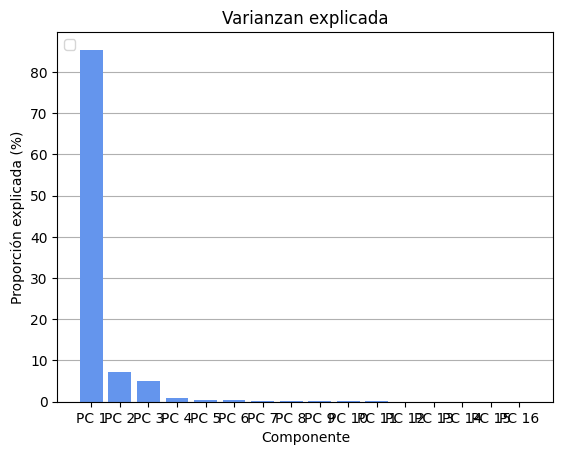

In [166]:
fig, ax = plt.subplots()

ax.set_title('Varianzan explicada')
ax.bar(range(len(data_pca.explained_variance_ratio_)),data_pca.explained_variance_ratio_*100, color='cornflowerblue')
ax.set_ylabel('Proporción explicada (%)')
ax.set_xlabel('Componente')
ax.set_xticks(range(16),['PC '+str(i+1) for i in range(16)])
ax.legend(loc='upper left')

#add horizontal gridlines behind bars in the plot
ax.set_axisbelow(True)
ax.grid(axis='y')

#display plot
plt.show()

In [167]:
pca_train.shape[1]

16

In [173]:
data_dim = pca_train.shape[1]

Xin = Input(shape=(data_dim,),name='In')

#Encoder 
#X = BatchNormalization()(Xin)
X = Dropout(rate = 0.5)(Xin)
X = Dense(data_dim)(Xin)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)

#Code
code_rep = Dense(5, activation='tanh')(X)
CODE = Model(inputs = Xin, outputs = [code_rep], name = "Encode")

#Decoder
#X = Dropout(rate = 0.1)(code_rep)
X = Dense(data_dim)(code_rep)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
X = LeakyReLU()(X)
X = Dense(data_dim)(X)
Decoded = LeakyReLU()(X)

AUTOENCODER = Model(inputs = Xin, outputs = [Decoded], name = 'Auto_encoder')

In [174]:
#AUTOENCODER.load_weights('S4D_Her0/AUTOENCODER_final.h5')

In [177]:
epochs     = 3000        # número de epocas
batch_size = 1000         # tamaño del lote
alpha      = 0.0001     # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

AUTOENCODER.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                      loss      = 'mse',
                      metrics   = ['accuracy'])

#Jengi_train.summary()

history = AUTOENCODER.fit(x                = pca_train,
                          y                = pca_train,
                          batch_size       = batch_size,
                          epochs           = epochs,
                          validation_split = 0.2,
                          verbose          = 1)

Epoch 1/3000
20/20 [==============================] - 1s 16ms/step - loss: 0.2699 - accuracy: 0.9979 - val_loss: 0.2165 - val_accuracy: 0.9990
Epoch 2/3000
20/20 [==============================] - 0s 7ms/step - loss: 0.2253 - accuracy: 0.9987 - val_loss: 0.2170 - val_accuracy: 0.9994
Epoch 3/3000
20/20 [==============================] - 0s 9ms/step - loss: 0.2206 - accuracy: 0.9987 - val_loss: 0.2144 - val_accuracy: 0.9994
Epoch 4/3000
20/20 [==============================] - 0s 8ms/step - loss: 0.2197 - accuracy: 0.9988 - val_loss: 0.2143 - val_accuracy: 0.9992
Epoch 5/3000
20/20 [==============================] - 0s 8ms/step - loss: 0.2197 - accuracy: 0.9987 - val_loss: 0.2143 - val_accuracy: 0.9992
Epoch 6/3000
20/20 [==============================] - 0s 9ms/step - loss: 0.2196 - accuracy: 0.9987 - val_loss: 0.2143 - val_accuracy: 0.9992
Epoch 7/3000
20/20 [==============================] - 0s 8ms/step - loss: 0.2196 - accuracy: 0.9986 - val_loss: 0.2142 - val_accuracy: 0.9992
Epoch

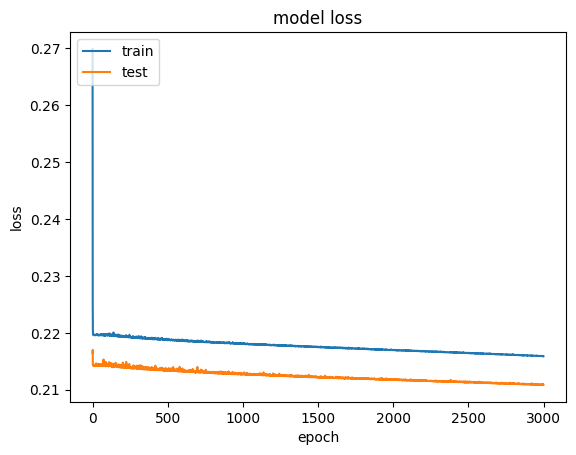

In [178]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [301]:
#AUTOENCODER.save_weights("S4D_Her0/AUTOENCODER_final.h5")

In [189]:
res = CODE.predict(pca_train)
res_df = pd.DataFrame(res)
data_plot_plotly(res_df, hue = pca_train['PromedioConstruccion'])

754/754 [==============================] - 1s 1ms/step


In [85]:
pca_train.columns

Index(['Fecha', 'Estacionamiento', 'Edad', 'Conservacion', 'AreaTerreno',
       'AreaConstruccion', 'PromedioConstruccion', 'PromedioTerreno',
       'Valorcomercial'],
      dtype='object')

In [127]:
data_plot_plotly(res_df, hue = pca_train['Fecha'])

In [190]:
fig = px.scatter_3d(
    res, x=0, y=1, z=2, color=pca_train['Calle'],
    labels={'0': 'CE 1', '1': 'CE 2', '2': 'CE 3'},
)
fig.update_traces(marker_size = 1)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [191]:
fig = px.scatter_3d(
    res, x=1, y=2, z=3, color=pca_train['PromedioConstruccion'],
    labels={'1': 'CE 2', '2': 'CE 3', '3': 'CE 4'},
)
fig.update_traces(marker_size = 1)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [205]:
#print(LMAPE(price_encoded, price_decoded))
print(pca_train[:10])
print(price_decoded[:10])

0.004905509523079617
[ 247328.  165675. 1542273.   54705.   64184.  170437.  652150.  146460.
   89383.  143374.]
[ 246879.73   165941.02  1499461.2     55063.137   64492.805  170917.39
  650554.4    146178.92    89835.25   143048.4  ]


In [182]:
X_train = pca_train.drop('Valorcomercial', axis = 1)
Y_train = CODE.predict(pca_train)

754/754 [==============================] - 1s 1ms/step


In [183]:
X_train.shape[1]

15

In [184]:
Xin = Input(shape=(X_train.shape[1],),name='In')
#X = Dropout(rate = 0.1)(Xin)
#X = BatchNormalization()(X)
X = Dense(10)(Xin)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
X = Dense(10)(X)
X = LeakyReLU()(X)
cbrt_price = Dense(1, activation='relu')(X)
CBRT_predictor = Model(inputs = Xin, outputs = [cbrt_price], name = "Predictor")

in_completed = Concatenate(axis=1, name = 'completion')([Xin,cbrt_price])
#in_completed = Add(name = 'completion')([Xin,completion])
#CODE.trainable = False
Yout = CODE(in_completed)

CODE_Trainer = Model(inputs = Xin, outputs = [Yout], name = 'encode_train')

In [133]:
CBRT_predictor.load_weights('S4D_Her0/CBRT_predictor.h5')

In [303]:
#CBRT_predictor.save_weights('S4D_Her0/CBRT_predictor.h5')

In [185]:
epochs     = 4500#1500        # número de epocas
batch_size = 1000         # tamaño del lote
alpha      = 0.001     # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

CODE_Trainer.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                       loss      = 'mae',
                       metrics   = ['accuracy'])

#Jengi_train.summary()

history = CODE_Trainer.fit(x                = X_train,
                             y                = Y_train,
                             batch_size       = batch_size,
                             epochs           = epochs,
                             validation_split = 0.2,
                             verbose          = 1)

Epoch 1/4500
20/20 [==============================] - 1s 16ms/step - loss: 0.0684 - accuracy: 0.9998 - val_loss: 0.0399 - val_accuracy: 1.0000
Epoch 2/4500
20/20 [==============================] - 0s 8ms/step - loss: 0.0335 - accuracy: 0.9999 - val_loss: 0.0295 - val_accuracy: 1.0000
Epoch 3/4500
20/20 [==============================] - 0s 7ms/step - loss: 0.0277 - accuracy: 0.9999 - val_loss: 0.0247 - val_accuracy: 1.0000
Epoch 4/4500
20/20 [==============================] - 0s 6ms/step - loss: 0.0227 - accuracy: 0.9999 - val_loss: 0.0202 - val_accuracy: 1.0000
Epoch 5/4500
20/20 [==============================] - 0s 6ms/step - loss: 0.0187 - accuracy: 0.9999 - val_loss: 0.0172 - val_accuracy: 1.0000
Epoch 6/4500
20/20 [==============================] - 0s 7ms/step - loss: 0.0165 - accuracy: 0.9999 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 7/4500
20/20 [==============================] - 0s 7ms/step - loss: 0.0154 - accuracy: 0.9999 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch

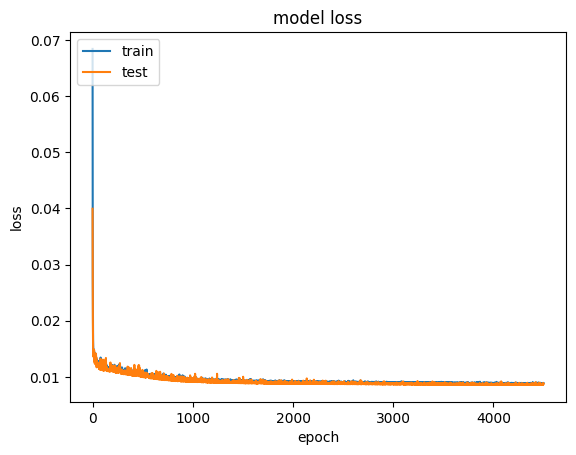

In [186]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [187]:
X_test = pca_test.drop('Valorcomercial', axis = 1)
Y_test = pca_test['Valorcomercial'].to_numpy()

res = CBRT_predictor.predict(X_test)
Y_hat = res.T[0]

188/188 [==============================] - 0s 1ms/step


In [188]:
print(MAPE(Y_test**3, Y_hat**3))
print(Y_test[:10]**3)
print(Y_hat[:10]**3)

0.9968596058696323
[785696. 108507. 482375. 289767.  85800. 259739. 103740.  91026. 394772.
 125710.]
[1039.5459   280.41116  794.05005  795.9883   345.51257 1227.8945
  639.5998   414.0895   841.14124  279.71164]


In [64]:
region_tester, region_test_gt = data_sanitize_test(raw_test_master, augmenter, region = ('Provincia','Lima'))
reg_test = region_tester.drop(UNINTERESTING_A, axis = 1)

X_test = reg_test.drop('Valorcomercial', axis = 1)
Y_test = reg_test['Valorcomercial'].to_numpy()

res = CBRT_predictor.predict(X_test)
Yp_hat = res.T[0]

187/187 [==============================] - 0s 957us/step


In [65]:
print(MSE(Y_test, Yp_hat))
print(Y_test[:10])
print(Yp_hat[:10])

17830.21497535801
[67.41701737 81.17823881 46.23415576 55.94690972 44.03268921 77.9052103
 53.44726512 49.73648025 50.61324779 46.05129753]
[171.61429 152.95502 125.43642 244.90154 190.60449 177.59673 175.17206
 210.61327 176.84383 114.38555]


In [66]:
resp_df = pd.DataFrame(resp**3, columns = pca_test.columns)
data_plot_plotly(resp_df, hue = np.cbrt(Yp_hat))

NameError: name 'resp' is not defined

In [212]:
Xp_df = pd.DataFrame(Xp_test, columns = pca_test.columns)
data_plot_plotly(Xp_df, hue = np.cbrt(Yp_hat))